In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize, unnormalize

from activephasemap.models.np.neural_process import NeuralProcess
from activephasemap.utils.settings import initialize_model
from activephasemap.utils.simulators import UVVisExperiment

import sys 
sys.path.append("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/6D")
from viz import ManifoldGridViz

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 12,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
               
              } 

In [3]:
ITERATION = 3
DATA_DIR = "./"
design_space_bounds = [(0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0), 
                       (0.0, 11.0),
                       ]

expt = UVVisExperiment(design_space_bounds, ITERATION, DATA_DIR+"/data/")
expt.generate(use_spline=True)
gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-5, "verbose": 1}
np_model_args = {"num_iterations": 1, "verbose":True, "print_freq":100, "lr":5e-4}
input_dim = expt.dim
output_dim = 2 

# Load trained GP model for p(z|c)
train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
bounds = expt.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_model = initialize_model(normalized_x, train_y, gp_model_args, input_dim, output_dim, device)
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
gp_model.load_state_dict(gp_state_dict)

# Load trained NP model for p(y|z)
np_model = NeuralProcess(1, 1, 128, 2, 128).to(device)
np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(ITERATION), map_location=device))

Loading data from iteration 0 with shapes: (72, 5) (72, 101)
Loading data from iteration 1 with shapes: (87, 5) (87, 101)
Loading data from iteration 2 with shapes: (86, 5) (86, 101)


<All keys matched successfully>

### Plot few samples from Nueral Process Model

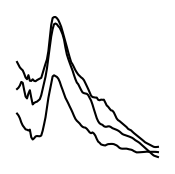

In [4]:
x_target = torch.Tensor(np.linspace(0, 1, 100)).to(device)
x_target = x_target.unsqueeze(1).unsqueeze(0)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(2,2))
    z_sample = torch.randn((3, 2)).to(device)
    for i in range(3):
        mu, _ = np_model.xz_to_y(x_target, z_sample[i,:])
        ax.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], color='k')
        ax.locator_params(tight=True, nbins=4)
        ax.axis('off')
    plt.show()

In [5]:
n = 5
inary = 4
viz = ManifoldGridViz(num_grid_samples=n, dim=inary)
viz.reduce() 

corners = np.eye(inary)
POS_CORNERS = np.asarray([viz.look_up(ci) for ci in corners])
POS_ZERO = viz.look_up(np.zeros(inary))
CORNER_NAMES = ["HEPES", "Z2M246I", "Au", "Z2"]

dense_viz = ManifoldGridViz(num_grid_samples=15, dim=inary)
dense_viz.reduce() 

DENSE_POS_CORNERS = np.asarray([dense_viz.look_up(ci) for ci in corners])

### Plot phase map as predicted by the trained model
This requires us to pass composition to a GP model which predicts latent variables `z_pred`. The predicted `z_pred` are used to inturn sample a curve that is representative of the spectroscopic measurement at given composition.

In [6]:
from activephasemap.utils.settings import from_comp_to_spectrum

with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(1,3, figsize=(4*3,4))

    for i, time in enumerate([1.0, 5.0, 10.0]):
        ax = axs[i]
        ax.set_title("%d min"%time, y=1.05)
        for i, pt in enumerate(viz.grid):
            composition = unnormalize(pt, np.asarray(design_space_bounds)[:4,:].T)
            loc_ax = ax.transLimits.transform(normalize(viz.pos[i,:], 
                                                        np.vstack((viz.pos.min(axis=0), viz.pos.max(axis=0))))
                                                        )
            ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.1,0.1])
            mu, sigma = from_comp_to_spectrum(expt, 
                                              gp_model, 
                                              np_model, 
                                              np.hstack((composition, time)).reshape(1,-1)
                                            )
            mu_ = mu.cpu().squeeze().numpy()
            sigma_ = sigma.cpu().squeeze().numpy()
            ins_ax.plot(expt.wl, mu_, color='k')
            # ins_ax.fill_between(test_function.sim.wav, mu_-sigma_, mu_+sigma_, color='grey')
            ins_ax.axis('off') 

        ax.scatter(viz.pos[:,0], viz.pos[:,1], color="k", alpha=0.02)

        for i, cname in enumerate(CORNER_NAMES):
            ax.scatter(POS_CORNERS[i,0], POS_CORNERS[i,1], s=50, color='tab:red')
            ax.text(POS_CORNERS[i,0], POS_CORNERS[i,1], cname) 

        ax.axis("off")
    plt.show()

### Plot collected data as points on a 2D plane

Plotting trained data...
Total of 159 samples collected so far...
Finished plotting trained spectra.


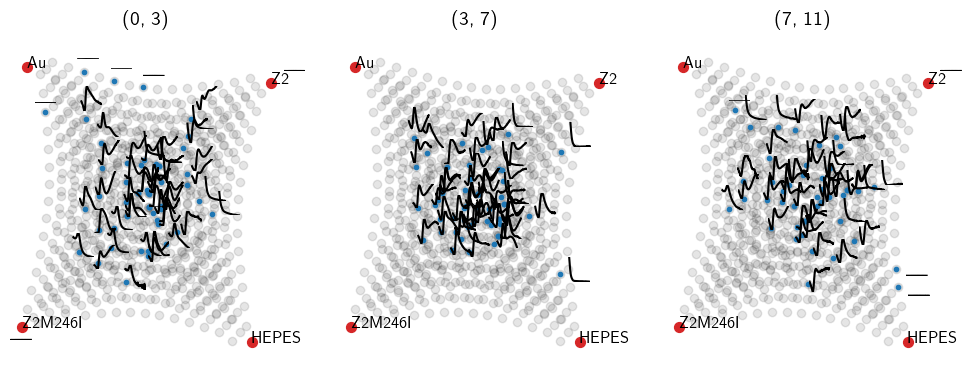

In [ ]:
with plt.style.context(pyplot_style):
    print("Plotting trained data...")
    num_samples = expt.comps.shape[0]
    print("Total of %d samples collected so far..."%num_samples)
    volumes, times = expt.comps[:,:-1], expt.comps[:,-1]
    water = np.abs(volumes.sum(axis=1)-280)

    concentration = volumes/water[:,np.newaxis]
    volfracs = concentration/concentration.sum(axis=1)[:,np.newaxis]
    pos_data = np.asarray([dense_viz.look_up(xi) for xi in volfracs])  

    fig, axs = plt.subplots(1,3, figsize=(4*3,4))
    plot_times = [(0.0, 3.0), (3.0, 7.0), (7.0, 11.0)]
    bounds = np.vstack((dense_viz.pos.min(axis=0), dense_viz.pos.max(axis=0)))
    for i, ax in enumerate(axs):
        ax.set_title("(%d, %d)"%(plot_times[i]), y=1.05)
        flags = np.logical_and(times>plot_times[i][0], times<plot_times[i][1])
        for i in np.argwhere(flags).squeeze():
            loc_ax = ax.transLimits.transform(normalize(pos_data[i,:], bounds))
            si = expt.spectra[i,:]
            ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.08,0.08])
            ins_ax.patch.set_alpha(0.1)
            if (si<0.05).all():
                ins_ax.plot(expt.wav, si, color="k")
                ins_ax.set_ylim([0, 1])
            else:
                norm = np.sqrt(np.trapz(si**2, expt.wav))
                si_norm =  si/norm
                ins_ax.plot(expt.wav, si_norm, color="k")
                ins_ax.set_ylim([min(si_norm), max(si_norm)])
            ins_ax.axis('off') 

        ax.scatter(dense_viz.pos[:,0], dense_viz.pos[:,1], color="k", alpha=0.1, edgecolors=None)
        ax.scatter(pos_data[flags,0], pos_data[flags,1], s=10)

        for i, cname in enumerate(CORNER_NAMES):
            ax.scatter(DENSE_POS_CORNERS[i,0], DENSE_POS_CORNERS[i,1], s=50, color='tab:red')
            ax.text(DENSE_POS_CORNERS[i,0], DENSE_POS_CORNERS[i,1], cname) 
        ax.axis("off")
print("Finished plotting trained spectra.")
plt.show()

### Plot acquisiton function at any given iteration

The acquisiton function is called on a dense grid of composition and represents the model predictive uncertainity at any given point in the composition.

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_6487/2170946765.py:44: RuntimeWarning: invalid value encountered in divide
  next_x_volfracs = next_x_concentration/next_x_concentration.sum(axis=1)[:,np.newaxis]
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_6487/2170946765.py:44: RuntimeWarning: invalid value encountered in divide
  next_x_volfracs = next_x_concentration/next_x_concentration.sum(axis=1)[:,np.newaxis]
/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_6487/2170946765.py:44: RuntimeWarning: invalid value encountered in divide
  next_x_volfracs = next_x_concentration/next_x_concentration.sum(axis=1)[:,np.newaxis]


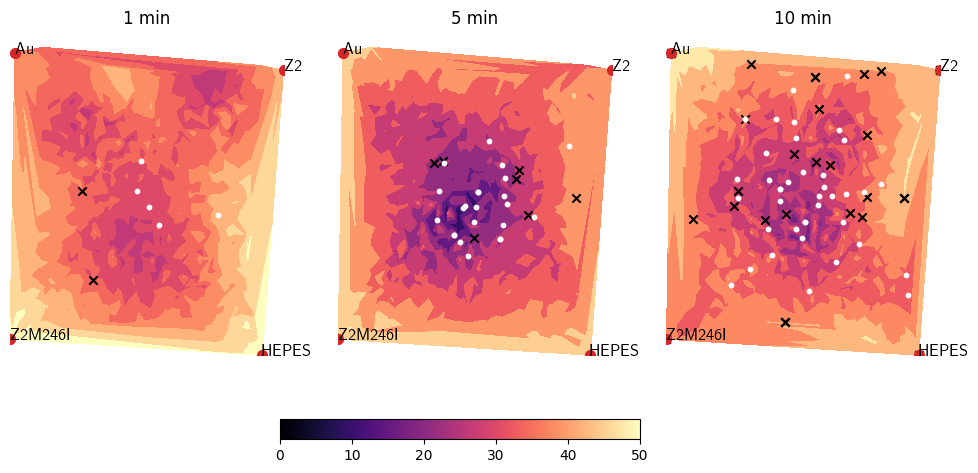

In [ ]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable
from activephasemap.utils.settings import construct_acqf_by_model

acquisition = construct_acqf_by_model(gp_model, normalized_x, train_y, output_dim)

comp_grid = unnormalize(dense_viz.grid, np.asarray(design_space_bounds)[:4,:].T)
fig, axs = plt.subplots(1,3,figsize=(4*3,4))
fig.subplots_adjust(wspace=0.2)
cmap = colormaps["magma"]
norm = Normalize(vmin=0, vmax = 50)
mappable = ScalarMappable(norm=norm, cmap=cmap)
divider = make_axes_locatable(axs[-1])
cax = fig.add_axes([0.35, -0.1, 0.3, 0.05])        
cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')

volumes, times = expt.comps[:,:-1], expt.comps[:,-1]
water = np.abs(volumes.sum(axis=1)-280)

concentration = volumes/water[:,np.newaxis]
volfracs = concentration/concentration.sum(axis=1)[:,np.newaxis]
pos_data = np.asarray([dense_viz.look_up(xi) for xi in volfracs])  

for i,time in enumerate([1.0, 5.0, 10.0]):
    ax = axs[i]
    ax.set_title("%d min"%time, y=1.05)
    time_delays = time*np.ones(comp_grid.shape[0])
    x_grid = np.hstack((comp_grid, time_delays.reshape(-1,1)))
    normalized_C_grid = normalize(torch.tensor(x_grid).to(train_x), expt.bounds.to(train_x))
    with torch.no_grad():
        acq_values = acquisition(normalized_C_grid.unsqueeze(1)).cpu().numpy()

    with plt.style.context(pyplot_style):
        ax.tricontourf(dense_viz.pos[:,0], dense_viz.pos[:,1], acq_values, cmap=cmap, norm=norm)

        next_x = np.load("./data/comps_%d.npy"%(ITERATION))
        next_x_compositon = next_x[:,:4]
        next_x_time = next_x[:,4]
        next_time_flags = np.isclose(next_x_time, time, 0.2)
        water_composition = 280-next_x_compositon.sum(axis=1)
        next_x_concentration = next_x_compositon/water_composition[:,np.newaxis]
        next_x_volfracs = next_x_concentration/next_x_concentration.sum(axis=1)[:,np.newaxis]
        next_x_viz = np.asarray([dense_viz.look_up(xi) for xi in next_x_volfracs[next_time_flags,:]])
        ax.scatter(next_x_viz[:,0], next_x_viz[:,1], color='k', marker='x')

        train_time_flags = np.isclose(times, time, 0.2)
        ax.scatter(pos_data[train_time_flags,0], pos_data[train_time_flags,1], color='w', s=10)

        for i, cname in enumerate(CORNER_NAMES):
            ax.scatter(DENSE_POS_CORNERS[i,0], DENSE_POS_CORNERS[i,1], s=50, color='tab:red')
            ax.text(DENSE_POS_CORNERS[i,0], DENSE_POS_CORNERS[i,1], cname) 
        ax.axis("off")
plt.show()

### Plot predictions of the model at trained compositions 
We randomly sample few training points and plot the model prediction to compare with the actual spectra

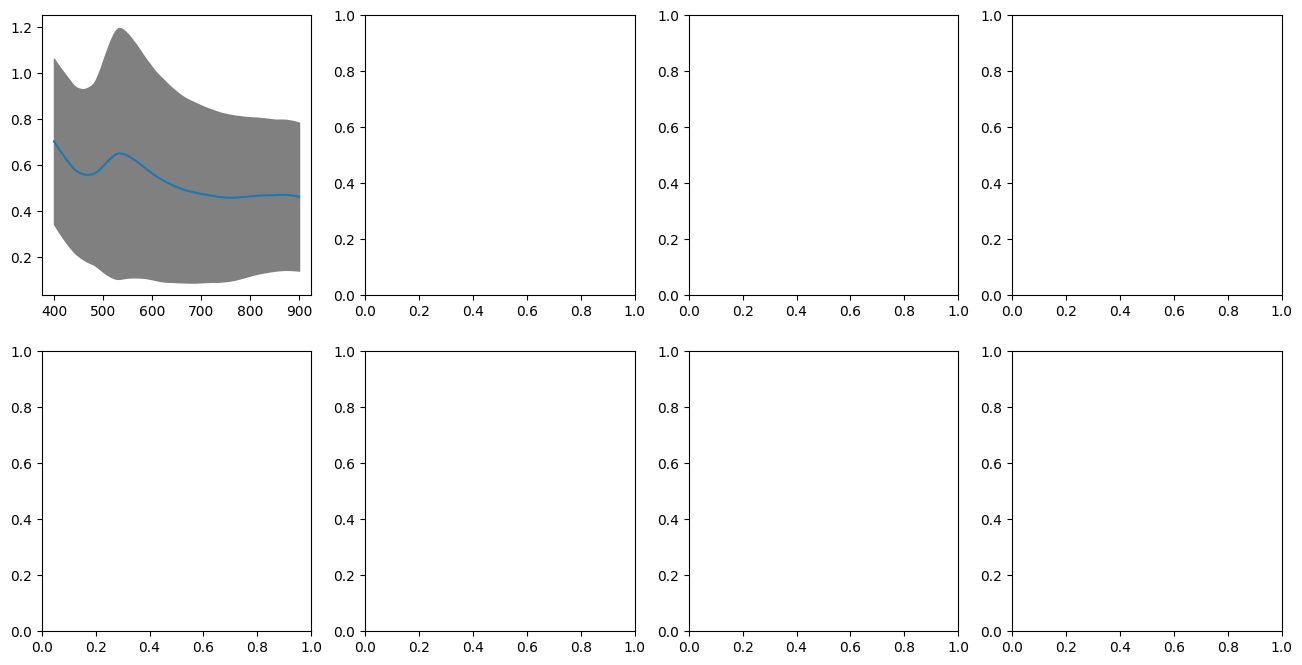

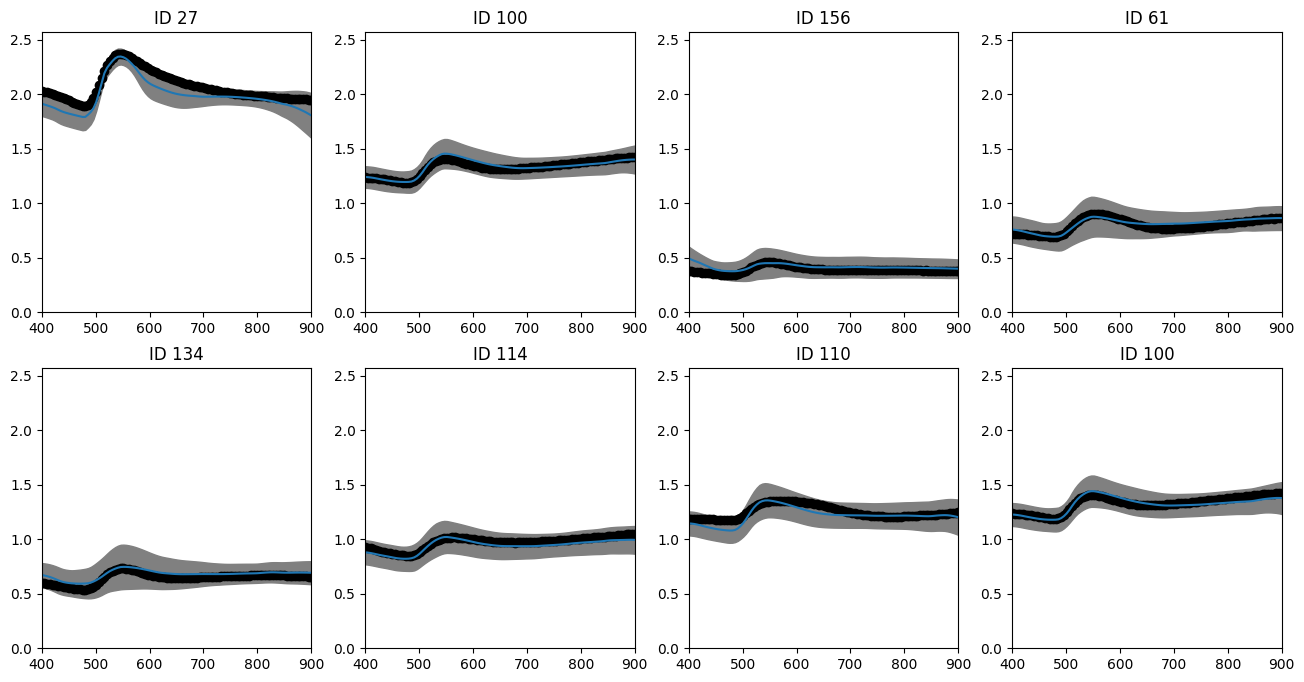

In [ ]:
from activephasemap.utils.visuals import plot_gpmodel_recon

fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
axs = axs.flatten() 
rids = np.random.randint(0, expt.comps.shape[0], size=8)
plot_comps = expt.comps[rids,:]
plot_spectra = expt.spectra_normalized[rids,:]
for i, ax in enumerate(axs):
    ci = plot_comps[i,:].reshape(1, -1)
    plot_gpmodel_recon(ax, gp_model, np_model, expt, ci)
    ax.scatter(expt.wl, plot_spectra[i,:], color='k')
    ax.set_title("ID %d"%rids[i])
    ax.set_ylim([0, plot_spectra.max()+0.2])
    ax.set_xlim([expt.wl.min(),expt.wl.max()])
plt.show()

### Plot predictions of the model at compositions it is currently requesting
We first predict the spectra at locations the model has requested to sample (because it has not seen spectra at those locations and thus are informative) and compare them with the actual sampled curve.

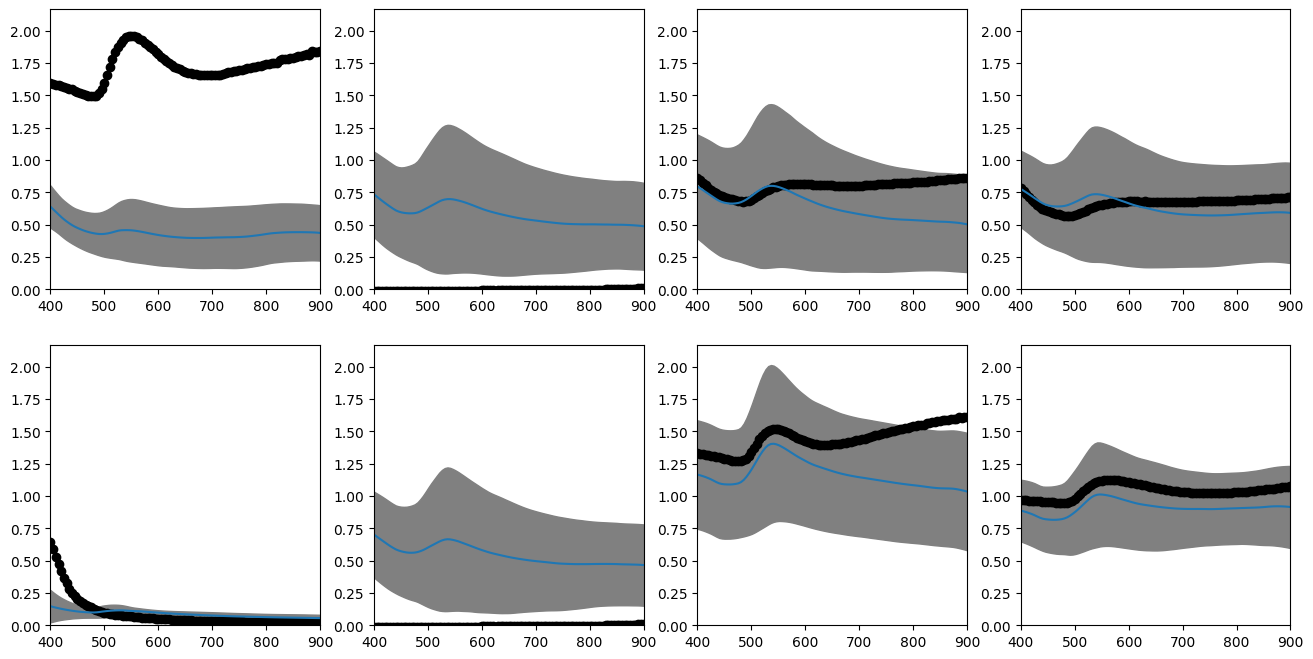

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
axs = axs.flatten()
next_comps = np.load(DATA_DIR+"/data/comps_%d.npy"%(ITERATION))
next_spectra = np.load(DATA_DIR+"/data/spectra_%d.npy"%(ITERATION))
wav = np.load(DATA_DIR+"/data/wav.npy")
rids = np.random.randint(0, next_comps.shape[0], size=8)
for i, ax in enumerate(axs):
    ci = next_comps[rids[i],:].reshape(1, -1)
    si = next_spectra[rids[i],:]
    plot_gpmodel_recon(ax, gp_model, np_model, expt, ci)
    ax.scatter(wav, si, color='k')
    ax.set_ylim([0, next_spectra.max()+0.2])
    ax.set_xlim([expt.wl.min(),expt.wl.max()])
plt.show()